## Notebook parameters

In [21]:
# Add the parameters tag to this cell
kedro_env = 'local'
# kedro_env = 'test_cloud'

In [22]:
relative_project_path = '..//'

## Imports

In [23]:
import yaml
import pandas as pd
from kedro_datasets.pandas import GBQTableDataSet, CSVDataSet
from kedro.io import PartitionedDataSet
from typing import Dict

## Loads kedro yml data

In [24]:
from kedro.config import ConfigLoader
from kedro.framework.project import settings

KEDRO_ENV = "local"
conf_path = str("../" + settings.CONF_SOURCE)
conf_loader = ConfigLoader(conf_source=conf_path, env=kedro_env)

conf_catalog = conf_loader["catalog"]

## Query using bigquery API for query debugging

In [25]:
# bq_query_cat_entry = catalog['bq_test']
# project_id = bq_query_cat_entry['project']

# Recovers contents of ARRAYS nested inside STRUCTS
# sql = """SELECT element.array_element
#     FROM bigquery-public-data.gbif.occurrences,
#     UNNEST(issue.array) AS element
#     LIMIT 20"""

# Shows the distinct values of the issue column, which is an ARRAY nested inside a STRUCT
# sql = """SELECT distinct element.array_element
#     FROM bigquery-public-data.gbif.occurrences,
#     UNNEST(issue.array) AS element"""

# Counts the number of observations per species and orders it from high to low
# sql = """ SELECT species,
#   count(species) as cnt
#   FROM bigquery-public-data.gbif.occurrences
#   group by species
#   order by cnt desc"""

# Counts the number of observations per species and orders it from high to low
# sql = """ SELECT species,
#   count(species) as cnt
#   FROM bigquery-public-data.gbif.occurrences
#   group by species
#   order by cnt desc"""

# Gets top 20 rows of all data
# sql = """ SELECT gbifid
#     ,datasetkey
#     ,occurrenceid
#     ,kingdom
#     ,phylum
#     ,class
#     ,`order`
#     ,family
#     ,genus
#     ,species
#     ,infraspecificepithet
#     ,taxonrank
#     ,scientificname
#     ,verbatimscientificname
#     ,verbatimscientificnameauthorship
#     ,countrycode
#     ,locality
#     ,stateprovince
#     ,occurrencestatus
#     ,individualcount
#     ,publishingorgkey
#     ,decimallatitude
#     ,decimallongitude
#     ,coordinateuncertaintyinmeters
#     ,coordinateprecision
#     ,elevation
#     ,elevationaccuracy
#     ,depth
#     ,depthaccuracy
#     ,eventdate
#     ,day
#     ,month
#     ,year
#     ,taxonkey
#     ,specieskey
#     ,basisofrecord
#     ,institutioncode
#     ,collectioncode
#     ,catalognumber
#     ,recordnumber
#     ,identifiedby
#     ,dateidentified
#     ,license
#     ,rightsholder
#     ,recordedby
#     ,typestatus
#     ,establishmentmeans
#     ,lastinterpreted
#     ,mediatype
#     ,issue
# FROM bigquery-public-data.gbif.occurrences
# LIMIT 20 """

# 
# sql = """SELECT gbifid
#     ,kingdom
#     ,phylum
#     ,class
#     ,`order`
#     ,family
#     ,genus
#     ,species
#     ,countrycode
#     ,occurrencestatus
#     ,individualcount
#     ,decimallatitude
#     ,decimallongitude
#     ,eventdate
#     ,day
#     ,month
#     ,year
#     ,basisofrecord 
#     ,element.array_element as issue
#     FROM bigquery-public-data.gbif.occurrences
#     CROSS JOIN UNNEST(issue.array) AS element
#     WHERE species = 'Anas platyrhynchos' AND eventdate > '2020-01-01'
#     """

# data_set = GBQQueryDataSet(sql, project=project_id)
# df = data_set.load()

## Loads csv with data downladed from bigquery

In [26]:
catalog_entry = 'species_data'
path = relative_project_path + conf_catalog[catalog_entry]['path']

In [27]:
def load_kedro_partitionedDS(path: str, dataset: Dict) -> pd.DataFrame:
    """Loads as a single dataframe the partitioned data stored in path.

    Parameters
    ----------
    path : str
        Path of the partitioned data
    dataset : Dict
        Type of data to search for and load options (dataset option in kedro's catalog of type PartitionedDataSet)

    Returns
    -------
    pd.DataFrame
        joined dataset
    """
    data_set = PartitionedDataSet(
        path=path,
        dataset=dataset,
    )

    print(dataset)

    loaded = data_set.load()

    df = pd.DataFrame()
    for partition_id, partition_load_func in loaded.items():
        partition_data = partition_load_func()
        df = pd.concat(
            [df, partition_data], ignore_index=True, sort=True
        )
    return df 



In [28]:
if kedro_env == 'local':
    dataset = conf_catalog[catalog_entry]['dataset']
    df = load_kedro_partitionedDS(path, dataset)
elif kedro_env == 'test_cloud':
    data_set = CSVDataSet(filepath=path)
    df = data_set.load()
else:
    raise ValueError('Undefined kedro environment')

{'type': 'pandas.CSVDataSet', 'load_args': {'sep': ','}}


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8964309 entries, 0 to 8964308
Data columns (total 19 columns):
 #   Column            Dtype  
---  ------            -----  
 0   basisofrecord     object 
 1   class             object 
 2   countrycode       object 
 3   day               float64
 4   decimallatitude   float64
 5   decimallongitude  float64
 6   eventdate         object 
 7   family            object 
 8   gbifid            int64  
 9   genus             object 
 10  individualcount   float64
 11  issue             object 
 12  kingdom           object 
 13  month             float64
 14  occurrencestatus  object 
 15  order             object 
 16  phylum            object 
 17  species           object 
 18  year              int64  
dtypes: float64(5), int64(2), object(12)
memory usage: 1.3+ GB


## Generates sample data for automatic testing

In [30]:
# NBVAL_SKIP
# test_catalog_entry = 'species_data'
# test_path = '..//' + conf_catalog[test_catalog_entry]['path']

# sample_index = combine_all.species.sample(1000).index
# sample_df = combine_all.loc[sample_index]
# sample_df.to_csv(test_path)

In [31]:
# sample_df

## Groups up data by observations per day/month and plots the results

In [39]:
group_cat = 'M'  #Choose either 'D' for day or 'M' for month
count_col = 'individualcount'
date_col = 'eventdate'
date_col_datetime = date_col + '_datetime'

df[date_col_datetime] = pd.to_datetime( df[date_col])
df[count_col] = df[count_col].fillna(0)
df_out = df[[count_col, date_col_datetime]]
df_out = df_out.set_index(date_col_datetime).resample(group_cat).sum()


<Axes: title={'center': 'Observations per month'}, xlabel='eventdate_datetime'>

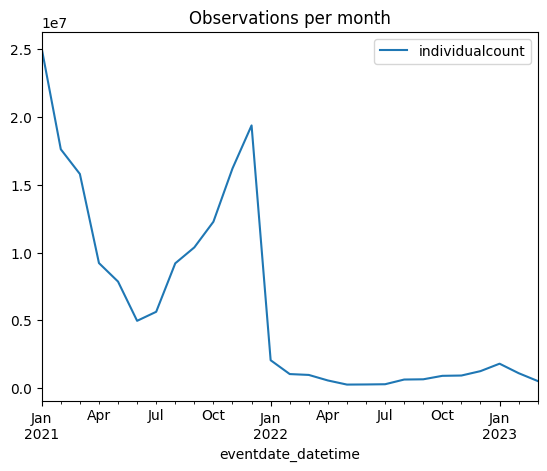

In [40]:
title = 'Observations per '
if group_cat == 'D':
    title = title + 'day'
elif group_cat == 'M':
    title = title + 'month'    
df_out.plot(title=title)